In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM, Dense 

In [ ]:
data=pd.read_excel('C:/Users/hatice.kocabas/Desktop/Demir Cevheri Fiyat Tahmini/data_v1.xlsx')

In [3]:
data.shape

(2715, 7)

In [4]:
data.head()

,Date,Demir Cevheri Fiyatı,Brent Petrol Fiyatı,Dolar Alış,Dolar Satış,TÜFE (Yıllık % Değişim),TÜFE (Aylık % Değişim)
0,2014-01-02,133.33,107.78,2.1304,2.1343,7.75,1.98
1,2014-01-03,132.71,106.89,2.1718,2.1757,7.75,1.98
2,2014-01-06,132.18,106.73,2.1687,2.1726,7.75,1.98
3,2014-01-07,132.02,107.35,2.1878,2.1918,7.75,1.98
4,2014-01-08,131.93,107.15,2.1723,2.1762,7.75,1.98


In [5]:
data.tail()

,Date,Demir Cevheri Fiyatı,Brent Petrol Fiyatı,Dolar Alış,Dolar Satış,TÜFE (Yıllık % Değişim),TÜFE (Aylık % Değişim)
2710,2024-10-14,107.11,77.46,34.1625,34.2241,NaN,NaN
2711,2024-10-15,106.63,74.25,34.2034,34.2650,NaN,NaN
2712,2024-10-16,106.20,74.22,34.2018,34.2634,NaN,NaN
2713,2024-10-17,105.36,74.45,34.1633,34.2248,NaN,NaN
2714,2024-10-18,105.37,73.06,34.1155,34.1769,NaN,NaN


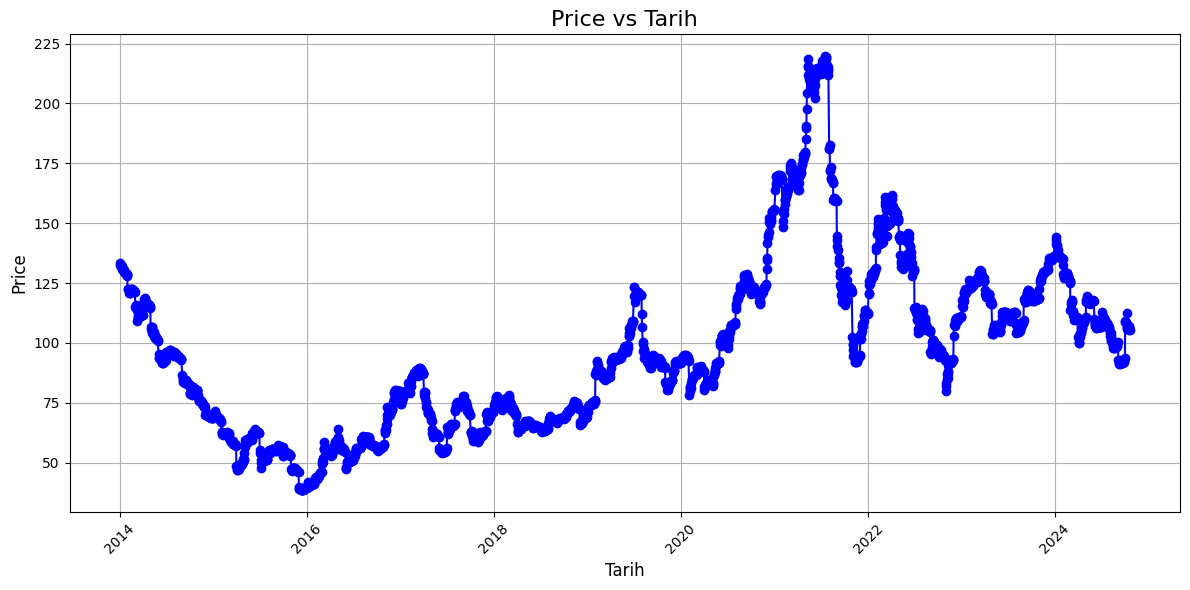

In [6]:
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Demir Cevheri Fiyatı'], marker='o', linestyle='-', color='b')

plt.title("Price vs Tarih", fontsize=16)
plt.xlabel("Tarih", fontsize=12)
plt.ylabel("Price", fontsize=12)

plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

In [7]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data.isnull().sum()

Demir Cevheri Fiyatı        0
Brent Petrol Fiyatı         0
Dolar Alış                 94
Dolar Satış                94
TÜFE (Yıllık % Değişim)    14
TÜFE (Aylık % Değişim)     14
dtype: int64

In [8]:
data['Dolar Alış '] = data['Dolar Alış '].ffill()
data['Dolar Satış'] = data['Dolar Satış'].ffill()
data['TÜFE (Yıllık % Değişim)'] = data['TÜFE (Yıllık % Değişim)'].ffill()
data['TÜFE (Aylık % Değişim)'] = data['TÜFE (Aylık % Değişim)'].ffill()

In [9]:
correlation_matrix = data.corr()

target_correlation = correlation_matrix['Demir Cevheri Fiyatı']
print(target_correlation)

Demir Cevheri Fiyatı       1.000000
Brent Petrol Fiyatı        0.420864
Dolar Alış                 0.412920
Dolar Satış                0.412920
TÜFE (Yıllık % Değişim)    0.400857
TÜFE (Aylık % Değişim)     0.337225
Name: Demir Cevheri Fiyatı, dtype: float64


In [10]:
target = 'Demir Cevheri Fiyatı'
features = data.drop(columns=[target])
target_data = data[[target]]

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target_data)

In [11]:
def create_dataset(features, target, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step - 1):
        X.append(np.hstack((features[i:(i + time_step)], target[i:(i + time_step)])))
        y.append(target[i + time_step])
    return np.array(X), np.array(y)

time_step = 30
X, y = create_dataset(scaled_features, scaled_target, time_step)



In [12]:
split_index = int(len(X) * 0.8)  # %80 eğitim, %20 test
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [13]:
num_features = X_train.shape[2]

In [14]:
num_features

6

In [15]:
model = Sequential()
model.add(LSTM(units=5, input_shape=(time_step, num_features)))
model.add(Dense(units=1))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_model = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100


c:\Users\hatice.kocabas\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0208 - val_loss: 0.0870
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0640
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0445
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0295
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9033e-04 - val_loss: 0.0212
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7843e-04 - val_loss: 0.0182
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7241e-04 - val_loss: 0.0173
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6682e-04 - val_loss: 0.0167
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2848e-04 - val_loss: 0.0171
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8406e-04 - val_loss: 0.0172
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5008e-04 - val_loss: 0.0178
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

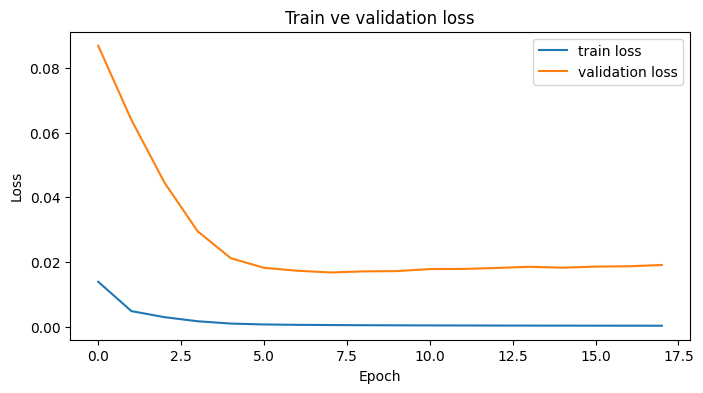

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(lstm_model.history['loss'], label='train loss')
plt.plot(lstm_model.history['val_loss'], label='validation loss')
plt.title('Train ve validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import mean_squared_error

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

print("Eğitim RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Eğitim RMSE:  0.06079931514465519
Test RMSE:  0.09253760402079615


In [18]:
mae = mean_absolute_error(y_test, test_predict)
mae

0.07904184432192937

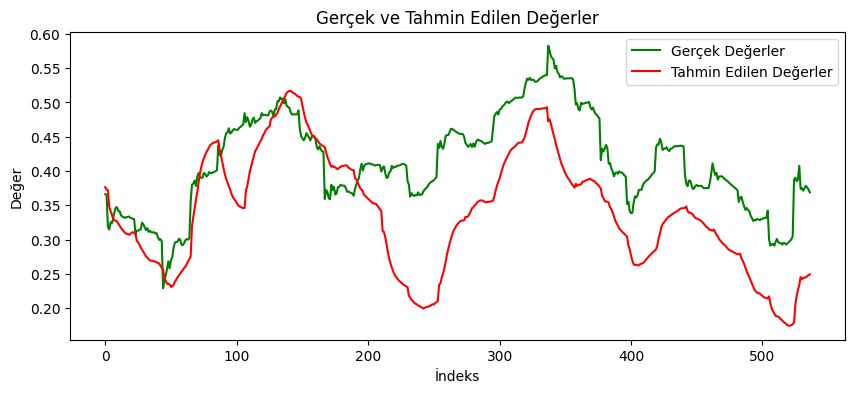

In [19]:

x = np.arange(len(y_test)) 

# Grafiği çizme
plt.figure(figsize=(10, 4))
plt.plot(x, y_test, label='Gerçek Değerler', color='green', marker=' ')
plt.plot(x, test_predict, label='Tahmin Edilen Değerler', color='red', marker=' ')
plt.title('Gerçek ve Tahmin Edilen Değerler')
plt.xlabel('İndeks')
plt.ylabel('Değer')
plt.legend()
plt.show()
